# Architektur Neuronales Netz

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=200, bias=True)
    (2): Tanh()
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): Tanh()
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): Tanh()
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 32 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000

# T = torch.tensor(res['T']).float()
# p = torch.tensor(res['p']).float()
# x_0 = torch.tensor(res['x_0']).float()
# xi = torch.tensor(res['xi']).float()

# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = xi.reshape((-1,1))
#print(x_input.size())
# print(xi.size())

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 1)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)

#### Funktion zur Bestimmung der Genauigkeit

In [7]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if pred[i] - y[i] <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [8]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients

#         # Record the correct predictions for training data
#         _, predictions = torch.max(pred.data, 1)
#         train_correct += (predictions == y.data).sum()                
#         train_total += predictions.size(0)    

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping
    #train_loss.append(loss.item())
    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

#     loss = criterion(outputs, Variable(test_classes))
#     test_loss.append(loss.data[0])

Epoch 1/200, Iteration 1/25, Loss: 0.1173
Epoch 1/200, Iteration 2/25, Loss: 1.3853
Epoch 1/200, Iteration 3/25, Loss: 2.8808
Epoch 1/200, Iteration 4/25, Loss: 1.9485
Epoch 1/200, Iteration 5/25, Loss: 0.8997
Epoch 1/200, Iteration 6/25, Loss: 0.3727
Epoch 1/200, Iteration 7/25, Loss: 0.7252
Epoch 1/200, Iteration 8/25, Loss: 0.7837
Epoch 1/200, Iteration 9/25, Loss: 0.6883
Epoch 1/200, Iteration 10/25, Loss: 0.4921
Epoch 1/200, Iteration 11/25, Loss: 0.1900
Epoch 1/200, Iteration 12/25, Loss: 0.4027
Epoch 1/200, Iteration 13/25, Loss: 0.4630
Epoch 1/200, Iteration 14/25, Loss: 0.3867
Epoch 1/200, Iteration 15/25, Loss: 0.4369
Epoch 1/200, Iteration 16/25, Loss: 0.2855
Epoch 1/200, Iteration 17/25, Loss: 0.2080
Epoch 1/200, Iteration 18/25, Loss: 0.2240
Epoch 1/200, Iteration 19/25, Loss: 0.1851
Epoch 1/200, Iteration 20/25, Loss: 0.1101
Epoch 1/200, Iteration 21/25, Loss: 0.1330
Epoch 1/200, Iteration 22/25, Loss: 0.0908
Epoch 1/200, Iteration 23/25, Loss: 0.1383
Epoch 1/200, Iterati

Epoch 8/200, Iteration 8/25, Loss: 0.0615
Epoch 8/200, Iteration 9/25, Loss: 0.0515
Epoch 8/200, Iteration 10/25, Loss: 0.0492
Epoch 8/200, Iteration 11/25, Loss: 0.0348
Epoch 8/200, Iteration 12/25, Loss: 0.0745
Epoch 8/200, Iteration 13/25, Loss: 0.0250
Epoch 8/200, Iteration 14/25, Loss: 0.0367
Epoch 8/200, Iteration 15/25, Loss: 0.0497
Epoch 8/200, Iteration 16/25, Loss: 0.0435
Epoch 8/200, Iteration 17/25, Loss: 0.0758
Epoch 8/200, Iteration 18/25, Loss: 0.0598
Epoch 8/200, Iteration 19/25, Loss: 0.0349
Epoch 8/200, Iteration 20/25, Loss: 0.0427
Epoch 8/200, Iteration 21/25, Loss: 0.0491
Epoch 8/200, Iteration 22/25, Loss: 0.0398
Epoch 8/200, Iteration 23/25, Loss: 0.0212
Epoch 8/200, Iteration 24/25, Loss: 0.0270
Epoch 8/200, Iteration 25/25, Loss: 0.0378
Train Error: 
 Accuracy: 60.12%, Avg loss: 0.032306, MRE: 1.736547 

Test Error: 
 Accuracy: 62.0%, Avg loss: 0.031616, MRE: 2.890306 

Epoch 9/200, Iteration 1/25, Loss: 0.0324
Epoch 9/200, Iteration 2/25, Loss: 0.0390
Epoch 9/

Epoch 15/200, Iteration 16/25, Loss: 0.0320
Epoch 15/200, Iteration 17/25, Loss: 0.0482
Epoch 15/200, Iteration 18/25, Loss: 0.0346
Epoch 15/200, Iteration 19/25, Loss: 0.0538
Epoch 15/200, Iteration 20/25, Loss: 0.0656
Epoch 15/200, Iteration 21/25, Loss: 0.0504
Epoch 15/200, Iteration 22/25, Loss: 0.0582
Epoch 15/200, Iteration 23/25, Loss: 0.0592
Epoch 15/200, Iteration 24/25, Loss: 0.0459
Epoch 15/200, Iteration 25/25, Loss: 0.0509
Train Error: 
 Accuracy: 48.38%, Avg loss: 0.050277, MRE: 3.415063 

Test Error: 
 Accuracy: 48.0%, Avg loss: 0.048607, MRE: 5.182220 

Epoch 16/200, Iteration 1/25, Loss: 0.0517
Epoch 16/200, Iteration 2/25, Loss: 0.0543
Epoch 16/200, Iteration 3/25, Loss: 0.0576
Epoch 16/200, Iteration 4/25, Loss: 0.0772
Epoch 16/200, Iteration 5/25, Loss: 0.0402
Epoch 16/200, Iteration 6/25, Loss: 0.0681
Epoch 16/200, Iteration 7/25, Loss: 0.0513
Epoch 16/200, Iteration 8/25, Loss: 0.0413
Epoch 16/200, Iteration 9/25, Loss: 0.0517
Epoch 16/200, Iteration 10/25, Loss: 

Epoch 23/200, Iteration 6/25, Loss: 0.0331
Epoch 23/200, Iteration 7/25, Loss: 0.0435
Epoch 23/200, Iteration 8/25, Loss: 0.0478
Epoch 23/200, Iteration 9/25, Loss: 0.0327
Epoch 23/200, Iteration 10/25, Loss: 0.0434
Epoch 23/200, Iteration 11/25, Loss: 0.0500
Epoch 23/200, Iteration 12/25, Loss: 0.0401
Epoch 23/200, Iteration 13/25, Loss: 0.0492
Epoch 23/200, Iteration 14/25, Loss: 0.0479
Epoch 23/200, Iteration 15/25, Loss: 0.0419
Epoch 23/200, Iteration 16/25, Loss: 0.0364
Epoch 23/200, Iteration 17/25, Loss: 0.0167
Epoch 23/200, Iteration 18/25, Loss: 0.0356
Epoch 23/200, Iteration 19/25, Loss: 0.0364
Epoch 23/200, Iteration 20/25, Loss: 0.0407
Epoch 23/200, Iteration 21/25, Loss: 0.0410
Epoch 23/200, Iteration 22/25, Loss: 0.0267
Epoch 23/200, Iteration 23/25, Loss: 0.0393
Epoch 23/200, Iteration 24/25, Loss: 0.0429
Epoch 23/200, Iteration 25/25, Loss: 0.0246
Train Error: 
 Accuracy: 59.13%, Avg loss: 0.034190, MRE: 2.384578 

Test Error: 
 Accuracy: 59.5%, Avg loss: 0.034073, MRE:

Epoch 30/200, Iteration 14/25, Loss: 0.0455
Epoch 30/200, Iteration 15/25, Loss: 0.0528
Epoch 30/200, Iteration 16/25, Loss: 0.0950
Epoch 30/200, Iteration 17/25, Loss: 0.0803
Epoch 30/200, Iteration 18/25, Loss: 0.0398
Epoch 30/200, Iteration 19/25, Loss: 0.0669
Epoch 30/200, Iteration 20/25, Loss: 0.0508
Epoch 30/200, Iteration 21/25, Loss: 0.0458
Epoch 30/200, Iteration 22/25, Loss: 0.0654
Epoch 30/200, Iteration 23/25, Loss: 0.0317
Epoch 30/200, Iteration 24/25, Loss: 0.0646
Epoch 30/200, Iteration 25/25, Loss: 0.0378
Train Error: 
 Accuracy: 82.88%, Avg loss: 0.063949, MRE: 4.759285 

Test Error: 
 Accuracy: 83.5%, Avg loss: 0.059787, MRE: 7.805303 

Epoch 31/200, Iteration 1/25, Loss: 0.0602
Epoch 31/200, Iteration 2/25, Loss: 0.0523
Epoch 31/200, Iteration 3/25, Loss: 0.0593
Epoch 31/200, Iteration 4/25, Loss: 0.0607
Epoch 31/200, Iteration 5/25, Loss: 0.0363
Epoch 31/200, Iteration 6/25, Loss: 0.0252
Epoch 31/200, Iteration 7/25, Loss: 0.0294
Epoch 31/200, Iteration 8/25, Loss:

Epoch 37/200, Iteration 25/25, Loss: 0.0146
Train Error: 
 Accuracy: 69.88%, Avg loss: 0.025654, MRE: 1.781981 

Test Error: 
 Accuracy: 67.0%, Avg loss: 0.024863, MRE: 3.636056 

Epoch 38/200, Iteration 1/25, Loss: 0.0240
Epoch 38/200, Iteration 2/25, Loss: 0.0296
Epoch 38/200, Iteration 3/25, Loss: 0.0277
Epoch 38/200, Iteration 4/25, Loss: 0.0158
Epoch 38/200, Iteration 5/25, Loss: 0.0188
Epoch 38/200, Iteration 6/25, Loss: 0.0235
Epoch 38/200, Iteration 7/25, Loss: 0.0286
Epoch 38/200, Iteration 8/25, Loss: 0.0319
Epoch 38/200, Iteration 9/25, Loss: 0.0236
Epoch 38/200, Iteration 10/25, Loss: 0.0471
Epoch 38/200, Iteration 11/25, Loss: 0.0164
Epoch 38/200, Iteration 12/25, Loss: 0.0213
Epoch 38/200, Iteration 13/25, Loss: 0.0163
Epoch 38/200, Iteration 14/25, Loss: 0.0138
Epoch 38/200, Iteration 15/25, Loss: 0.0260
Epoch 38/200, Iteration 16/25, Loss: 0.0123
Epoch 38/200, Iteration 17/25, Loss: 0.0134
Epoch 38/200, Iteration 18/25, Loss: 0.0189
Epoch 38/200, Iteration 19/25, Loss: 

Epoch 45/200, Iteration 17/25, Loss: 0.0266
Epoch 45/200, Iteration 18/25, Loss: 0.0273
Epoch 45/200, Iteration 19/25, Loss: 0.0430
Epoch 45/200, Iteration 20/25, Loss: 0.0418
Epoch 45/200, Iteration 21/25, Loss: 0.0304
Epoch 45/200, Iteration 22/25, Loss: 0.0175
Epoch 45/200, Iteration 23/25, Loss: 0.0178
Epoch 45/200, Iteration 24/25, Loss: 0.0168
Epoch 45/200, Iteration 25/25, Loss: 0.0182
Train Error: 
 Accuracy: 63.0%, Avg loss: 0.020985, MRE: 1.092948 

Test Error: 
 Accuracy: 61.0%, Avg loss: 0.021245, MRE: 2.967340 

Epoch 46/200, Iteration 1/25, Loss: 0.0169
Epoch 46/200, Iteration 2/25, Loss: 0.0305
Epoch 46/200, Iteration 3/25, Loss: 0.0236
Epoch 46/200, Iteration 4/25, Loss: 0.0192
Epoch 46/200, Iteration 5/25, Loss: 0.0160
Epoch 46/200, Iteration 6/25, Loss: 0.0202
Epoch 46/200, Iteration 7/25, Loss: 0.0265
Epoch 46/200, Iteration 8/25, Loss: 0.0120
Epoch 46/200, Iteration 9/25, Loss: 0.0207
Epoch 46/200, Iteration 10/25, Loss: 0.0140
Epoch 46/200, Iteration 11/25, Loss: 0

Epoch 53/200, Iteration 8/25, Loss: 0.0191
Epoch 53/200, Iteration 9/25, Loss: 0.0180
Epoch 53/200, Iteration 10/25, Loss: 0.0197
Epoch 53/200, Iteration 11/25, Loss: 0.0210
Epoch 53/200, Iteration 12/25, Loss: 0.0167
Epoch 53/200, Iteration 13/25, Loss: 0.0134
Epoch 53/200, Iteration 14/25, Loss: 0.0082
Epoch 53/200, Iteration 15/25, Loss: 0.0348
Epoch 53/200, Iteration 16/25, Loss: 0.0090
Epoch 53/200, Iteration 17/25, Loss: 0.0087
Epoch 53/200, Iteration 18/25, Loss: 0.0202
Epoch 53/200, Iteration 19/25, Loss: 0.0110
Epoch 53/200, Iteration 20/25, Loss: 0.0140
Epoch 53/200, Iteration 21/25, Loss: 0.0298
Epoch 53/200, Iteration 22/25, Loss: 0.0295
Epoch 53/200, Iteration 23/25, Loss: 0.0167
Epoch 53/200, Iteration 24/25, Loss: 0.0376
Epoch 53/200, Iteration 25/25, Loss: 0.0213
Train Error: 
 Accuracy: 68.62%, Avg loss: 0.009334, MRE: 0.768954 

Test Error: 
 Accuracy: 68.0%, Avg loss: 0.010810, MRE: 0.704464 

Epoch 54/200, Iteration 1/25, Loss: 0.0078
Epoch 54/200, Iteration 2/25, L

Train Error: 
 Accuracy: 90.75%, Avg loss: 0.008551, MRE: 0.428316 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.008588, MRE: 1.114013 

Epoch 61/200, Iteration 1/25, Loss: 0.0274
Epoch 61/200, Iteration 2/25, Loss: 0.0084
Epoch 61/200, Iteration 3/25, Loss: 0.0221
Epoch 61/200, Iteration 4/25, Loss: 0.0310
Epoch 61/200, Iteration 5/25, Loss: 0.0147
Epoch 61/200, Iteration 6/25, Loss: 0.0293
Epoch 61/200, Iteration 7/25, Loss: 0.0178
Epoch 61/200, Iteration 8/25, Loss: 0.0351
Epoch 61/200, Iteration 9/25, Loss: 0.0130
Epoch 61/200, Iteration 10/25, Loss: 0.0198
Epoch 61/200, Iteration 11/25, Loss: 0.0215
Epoch 61/200, Iteration 12/25, Loss: 0.0137
Epoch 61/200, Iteration 13/25, Loss: 0.0102
Epoch 61/200, Iteration 14/25, Loss: 0.0280
Epoch 61/200, Iteration 15/25, Loss: 0.0125
Epoch 61/200, Iteration 16/25, Loss: 0.0179
Epoch 61/200, Iteration 17/25, Loss: 0.0190
Epoch 61/200, Iteration 18/25, Loss: 0.0104
Epoch 61/200, Iteration 19/25, Loss: 0.0146
Epoch 61/200, Iteration 20/25, Loss: 

Epoch 67/200, Iteration 21/25, Loss: 0.0158
Epoch 67/200, Iteration 22/25, Loss: 0.0136
Epoch 67/200, Iteration 23/25, Loss: 0.0116
Epoch 67/200, Iteration 24/25, Loss: 0.0158
Epoch 67/200, Iteration 25/25, Loss: 0.0158
Train Error: 
 Accuracy: 52.0%, Avg loss: 0.011479, MRE: 0.720193 

Test Error: 
 Accuracy: 46.0%, Avg loss: 0.012205, MRE: 0.869473 

Epoch 68/200, Iteration 1/25, Loss: 0.0154
Epoch 68/200, Iteration 2/25, Loss: 0.0131
Epoch 68/200, Iteration 3/25, Loss: 0.0143
Epoch 68/200, Iteration 4/25, Loss: 0.0092
Epoch 68/200, Iteration 5/25, Loss: 0.0161
Epoch 68/200, Iteration 6/25, Loss: 0.0102
Epoch 68/200, Iteration 7/25, Loss: 0.0106
Epoch 68/200, Iteration 8/25, Loss: 0.0137
Epoch 68/200, Iteration 9/25, Loss: 0.0095
Epoch 68/200, Iteration 10/25, Loss: 0.0265
Epoch 68/200, Iteration 11/25, Loss: 0.0325
Epoch 68/200, Iteration 12/25, Loss: 0.0132
Epoch 68/200, Iteration 13/25, Loss: 0.0102
Epoch 68/200, Iteration 14/25, Loss: 0.0144
Epoch 68/200, Iteration 15/25, Loss: 0

Test Error: 
 Accuracy: 89.0%, Avg loss: 0.007291, MRE: 0.413196 

Epoch 75/200, Iteration 1/25, Loss: 0.0244
Epoch 75/200, Iteration 2/25, Loss: 0.0093
Epoch 75/200, Iteration 3/25, Loss: 0.0104
Epoch 75/200, Iteration 4/25, Loss: 0.0125
Epoch 75/200, Iteration 5/25, Loss: 0.0131
Epoch 75/200, Iteration 6/25, Loss: 0.0155
Epoch 75/200, Iteration 7/25, Loss: 0.0077
Epoch 75/200, Iteration 8/25, Loss: 0.0161
Epoch 75/200, Iteration 9/25, Loss: 0.0118
Epoch 75/200, Iteration 10/25, Loss: 0.0090
Epoch 75/200, Iteration 11/25, Loss: 0.0306
Epoch 75/200, Iteration 12/25, Loss: 0.0088
Epoch 75/200, Iteration 13/25, Loss: 0.0095
Epoch 75/200, Iteration 14/25, Loss: 0.0332
Epoch 75/200, Iteration 15/25, Loss: 0.0113
Epoch 75/200, Iteration 16/25, Loss: 0.0057
Epoch 75/200, Iteration 17/25, Loss: 0.0083
Epoch 75/200, Iteration 18/25, Loss: 0.0095
Epoch 75/200, Iteration 19/25, Loss: 0.0325
Epoch 75/200, Iteration 20/25, Loss: 0.0281
Epoch 75/200, Iteration 21/25, Loss: 0.0213
Epoch 75/200, Iter

Epoch 82/200, Iteration 17/25, Loss: 0.0133
Epoch 82/200, Iteration 18/25, Loss: 0.0086
Epoch 82/200, Iteration 19/25, Loss: 0.0091
Epoch 82/200, Iteration 20/25, Loss: 0.0093
Epoch 82/200, Iteration 21/25, Loss: 0.0162
Epoch 82/200, Iteration 22/25, Loss: 0.0268
Epoch 82/200, Iteration 23/25, Loss: 0.0175
Epoch 82/200, Iteration 24/25, Loss: 0.0132
Epoch 82/200, Iteration 25/25, Loss: 0.0140
Train Error: 
 Accuracy: 74.75%, Avg loss: 0.007461, MRE: 0.534536 

Test Error: 
 Accuracy: 73.0%, Avg loss: 0.007912, MRE: 0.468694 

Epoch 83/200, Iteration 1/25, Loss: 0.0329
Epoch 83/200, Iteration 2/25, Loss: 0.0354
Epoch 83/200, Iteration 3/25, Loss: 0.0102
Epoch 83/200, Iteration 4/25, Loss: 0.0173
Epoch 83/200, Iteration 5/25, Loss: 0.0079
Epoch 83/200, Iteration 6/25, Loss: 0.0111
Epoch 83/200, Iteration 7/25, Loss: 0.0082
Epoch 83/200, Iteration 8/25, Loss: 0.0120
Epoch 83/200, Iteration 9/25, Loss: 0.0217
Epoch 83/200, Iteration 10/25, Loss: 0.0143
Epoch 83/200, Iteration 11/25, Loss: 

Train Error: 
 Accuracy: 90.75%, Avg loss: 0.005512, MRE: 0.464842 

Test Error: 
 Accuracy: 88.5%, Avg loss: 0.006525, MRE: 0.429913 

Epoch 90/200, Iteration 1/25, Loss: 0.0110
Epoch 90/200, Iteration 2/25, Loss: 0.0380
Epoch 90/200, Iteration 3/25, Loss: 0.0243
Epoch 90/200, Iteration 4/25, Loss: 0.0093
Epoch 90/200, Iteration 5/25, Loss: 0.0099
Epoch 90/200, Iteration 6/25, Loss: 0.0092
Epoch 90/200, Iteration 7/25, Loss: 0.0229
Epoch 90/200, Iteration 8/25, Loss: 0.0101
Epoch 90/200, Iteration 9/25, Loss: 0.0091
Epoch 90/200, Iteration 10/25, Loss: 0.0202
Epoch 90/200, Iteration 11/25, Loss: 0.0135
Epoch 90/200, Iteration 12/25, Loss: 0.0226
Epoch 90/200, Iteration 13/25, Loss: 0.0147
Epoch 90/200, Iteration 14/25, Loss: 0.0084
Epoch 90/200, Iteration 15/25, Loss: 0.0264
Epoch 90/200, Iteration 16/25, Loss: 0.0194
Epoch 90/200, Iteration 17/25, Loss: 0.0074
Epoch 90/200, Iteration 18/25, Loss: 0.0152
Epoch 90/200, Iteration 19/25, Loss: 0.0115
Epoch 90/200, Iteration 20/25, Loss: 

Epoch 96/200, Iteration 18/25, Loss: 0.0191
Epoch 96/200, Iteration 19/25, Loss: 0.0128
Epoch 96/200, Iteration 20/25, Loss: 0.0102
Epoch 96/200, Iteration 21/25, Loss: 0.0157
Epoch 96/200, Iteration 22/25, Loss: 0.0183
Epoch 96/200, Iteration 23/25, Loss: 0.0054
Epoch 96/200, Iteration 24/25, Loss: 0.0110
Epoch 96/200, Iteration 25/25, Loss: 0.0130
Train Error: 
 Accuracy: 96.0%, Avg loss: 0.004957, MRE: 0.333986 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.005848, MRE: 0.687185 

Epoch 97/200, Iteration 1/25, Loss: 0.0148
Epoch 97/200, Iteration 2/25, Loss: 0.0103
Epoch 97/200, Iteration 3/25, Loss: 0.0151
Epoch 97/200, Iteration 4/25, Loss: 0.0127
Epoch 97/200, Iteration 5/25, Loss: 0.0146
Epoch 97/200, Iteration 6/25, Loss: 0.0062
Epoch 97/200, Iteration 7/25, Loss: 0.0077
Epoch 97/200, Iteration 8/25, Loss: 0.0084
Epoch 97/200, Iteration 9/25, Loss: 0.0127
Epoch 97/200, Iteration 10/25, Loss: 0.0146
Epoch 97/200, Iteration 11/25, Loss: 0.0120
Epoch 97/200, Iteration 12/25, Loss: 0

Epoch 104/200, Iteration 2/25, Loss: 0.0064
Epoch 104/200, Iteration 3/25, Loss: 0.0103
Epoch 104/200, Iteration 4/25, Loss: 0.0073
Epoch 104/200, Iteration 5/25, Loss: 0.0208
Epoch 104/200, Iteration 6/25, Loss: 0.0193
Epoch 104/200, Iteration 7/25, Loss: 0.0061
Epoch 104/200, Iteration 8/25, Loss: 0.0112
Epoch 104/200, Iteration 9/25, Loss: 0.0171
Epoch 104/200, Iteration 10/25, Loss: 0.0051
Epoch 104/200, Iteration 11/25, Loss: 0.0267
Epoch 104/200, Iteration 12/25, Loss: 0.0094
Epoch 104/200, Iteration 13/25, Loss: 0.0085
Epoch 104/200, Iteration 14/25, Loss: 0.0151
Epoch 104/200, Iteration 15/25, Loss: 0.0159
Epoch 104/200, Iteration 16/25, Loss: 0.0174
Epoch 104/200, Iteration 17/25, Loss: 0.0335
Epoch 104/200, Iteration 18/25, Loss: 0.0198
Epoch 104/200, Iteration 19/25, Loss: 0.0075
Epoch 104/200, Iteration 20/25, Loss: 0.0111
Epoch 104/200, Iteration 21/25, Loss: 0.0140
Epoch 104/200, Iteration 22/25, Loss: 0.0128
Epoch 104/200, Iteration 23/25, Loss: 0.0110
Epoch 104/200, Ite

Epoch 111/200, Iteration 19/25, Loss: 0.0160
Epoch 111/200, Iteration 20/25, Loss: 0.0097
Epoch 111/200, Iteration 21/25, Loss: 0.0058
Epoch 111/200, Iteration 22/25, Loss: 0.0145
Epoch 111/200, Iteration 23/25, Loss: 0.0074
Epoch 111/200, Iteration 24/25, Loss: 0.0125
Epoch 111/200, Iteration 25/25, Loss: 0.0079
Train Error: 
 Accuracy: 94.88%, Avg loss: 0.005207, MRE: 0.306155 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.005897, MRE: 0.832965 

Epoch 112/200, Iteration 1/25, Loss: 0.0101
Epoch 112/200, Iteration 2/25, Loss: 0.0087
Epoch 112/200, Iteration 3/25, Loss: 0.0106
Epoch 112/200, Iteration 4/25, Loss: 0.0113
Epoch 112/200, Iteration 5/25, Loss: 0.0227
Epoch 112/200, Iteration 6/25, Loss: 0.0134
Epoch 112/200, Iteration 7/25, Loss: 0.0169
Epoch 112/200, Iteration 8/25, Loss: 0.0053
Epoch 112/200, Iteration 9/25, Loss: 0.0181
Epoch 112/200, Iteration 10/25, Loss: 0.0245
Epoch 112/200, Iteration 11/25, Loss: 0.0148
Epoch 112/200, Iteration 12/25, Loss: 0.0223
Epoch 112/200, Ite

Epoch 119/200, Iteration 13/25, Loss: 0.0300
Epoch 119/200, Iteration 14/25, Loss: 0.0089
Epoch 119/200, Iteration 15/25, Loss: 0.0114
Epoch 119/200, Iteration 16/25, Loss: 0.0090
Epoch 119/200, Iteration 17/25, Loss: 0.0100
Epoch 119/200, Iteration 18/25, Loss: 0.0093
Epoch 119/200, Iteration 19/25, Loss: 0.0222
Epoch 119/200, Iteration 20/25, Loss: 0.0072
Epoch 119/200, Iteration 21/25, Loss: 0.0115
Epoch 119/200, Iteration 22/25, Loss: 0.0077
Epoch 119/200, Iteration 23/25, Loss: 0.0091
Epoch 119/200, Iteration 24/25, Loss: 0.0137
Epoch 119/200, Iteration 25/25, Loss: 0.0116
Train Error: 
 Accuracy: 95.25%, Avg loss: 0.005018, MRE: 0.310654 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.005763, MRE: 0.720817 

Epoch 120/200, Iteration 1/25, Loss: 0.0281
Epoch 120/200, Iteration 2/25, Loss: 0.0129
Epoch 120/200, Iteration 3/25, Loss: 0.0086
Epoch 120/200, Iteration 4/25, Loss: 0.0066
Epoch 120/200, Iteration 5/25, Loss: 0.0128
Epoch 120/200, Iteration 6/25, Loss: 0.0248
Epoch 120/200, 

Epoch 126/200, Iteration 24/25, Loss: 0.0277
Epoch 126/200, Iteration 25/25, Loss: 0.0192
Train Error: 
 Accuracy: 95.88%, Avg loss: 0.004865, MRE: 0.328610 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.005794, MRE: 0.501717 

Epoch 127/200, Iteration 1/25, Loss: 0.0267
Epoch 127/200, Iteration 2/25, Loss: 0.0166
Epoch 127/200, Iteration 3/25, Loss: 0.0109
Epoch 127/200, Iteration 4/25, Loss: 0.0154
Epoch 127/200, Iteration 5/25, Loss: 0.0170
Epoch 127/200, Iteration 6/25, Loss: 0.0162
Epoch 127/200, Iteration 7/25, Loss: 0.0048
Epoch 127/200, Iteration 8/25, Loss: 0.0124
Epoch 127/200, Iteration 9/25, Loss: 0.0270
Epoch 127/200, Iteration 10/25, Loss: 0.0062
Epoch 127/200, Iteration 11/25, Loss: 0.0161
Epoch 127/200, Iteration 12/25, Loss: 0.0135
Epoch 127/200, Iteration 13/25, Loss: 0.0173
Epoch 127/200, Iteration 14/25, Loss: 0.0094
Epoch 127/200, Iteration 15/25, Loss: 0.0051
Epoch 127/200, Iteration 16/25, Loss: 0.0197
Epoch 127/200, Iteration 17/25, Loss: 0.0134
Epoch 127/200, Ite

Epoch 133/200, Iteration 22/25, Loss: 0.0066
Epoch 133/200, Iteration 23/25, Loss: 0.0199
Epoch 133/200, Iteration 24/25, Loss: 0.0089
Epoch 133/200, Iteration 25/25, Loss: 0.0213
Train Error: 
 Accuracy: 94.5%, Avg loss: 0.005414, MRE: 0.321651 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.005810, MRE: 0.989354 

Epoch 134/200, Iteration 1/25, Loss: 0.0098
Epoch 134/200, Iteration 2/25, Loss: 0.0411
Epoch 134/200, Iteration 3/25, Loss: 0.0070
Epoch 134/200, Iteration 4/25, Loss: 0.0072
Epoch 134/200, Iteration 5/25, Loss: 0.0117
Epoch 134/200, Iteration 6/25, Loss: 0.0239
Epoch 134/200, Iteration 7/25, Loss: 0.0128
Epoch 134/200, Iteration 8/25, Loss: 0.0234
Epoch 134/200, Iteration 9/25, Loss: 0.0067
Epoch 134/200, Iteration 10/25, Loss: 0.0082
Epoch 134/200, Iteration 11/25, Loss: 0.0119
Epoch 134/200, Iteration 12/25, Loss: 0.0168
Epoch 134/200, Iteration 13/25, Loss: 0.0089
Epoch 134/200, Iteration 14/25, Loss: 0.0086
Epoch 134/200, Iteration 15/25, Loss: 0.0101
Epoch 134/200, Iter

Epoch 141/200, Iteration 6/25, Loss: 0.0283
Epoch 141/200, Iteration 7/25, Loss: 0.0171
Epoch 141/200, Iteration 8/25, Loss: 0.0270
Epoch 141/200, Iteration 9/25, Loss: 0.0074
Epoch 141/200, Iteration 10/25, Loss: 0.0370
Epoch 141/200, Iteration 11/25, Loss: 0.0278
Epoch 141/200, Iteration 12/25, Loss: 0.0073
Epoch 141/200, Iteration 13/25, Loss: 0.0207
Epoch 141/200, Iteration 14/25, Loss: 0.0083
Epoch 141/200, Iteration 15/25, Loss: 0.0066
Epoch 141/200, Iteration 16/25, Loss: 0.0066
Epoch 141/200, Iteration 17/25, Loss: 0.0242
Epoch 141/200, Iteration 18/25, Loss: 0.0387
Epoch 141/200, Iteration 19/25, Loss: 0.0105
Epoch 141/200, Iteration 20/25, Loss: 0.0356
Epoch 141/200, Iteration 21/25, Loss: 0.0126
Epoch 141/200, Iteration 22/25, Loss: 0.0227
Epoch 141/200, Iteration 23/25, Loss: 0.0066
Epoch 141/200, Iteration 24/25, Loss: 0.0102
Epoch 141/200, Iteration 25/25, Loss: 0.0183
Train Error: 
 Accuracy: 96.38%, Avg loss: 0.004921, MRE: 0.314744 

Test Error: 
 Accuracy: 96.5%, Avg 

Epoch 147/200, Iteration 22/25, Loss: 0.0068
Epoch 147/200, Iteration 23/25, Loss: 0.0152
Epoch 147/200, Iteration 24/25, Loss: 0.0268
Epoch 147/200, Iteration 25/25, Loss: 0.0303
Train Error: 
 Accuracy: 92.25%, Avg loss: 0.005135, MRE: 0.323643 

Test Error: 
 Accuracy: 89.5%, Avg loss: 0.005761, MRE: 0.614518 

Epoch 148/200, Iteration 1/25, Loss: 0.0091
Epoch 148/200, Iteration 2/25, Loss: 0.0175
Epoch 148/200, Iteration 3/25, Loss: 0.0161
Epoch 148/200, Iteration 4/25, Loss: 0.0079
Epoch 148/200, Iteration 5/25, Loss: 0.0113
Epoch 148/200, Iteration 6/25, Loss: 0.0064
Epoch 148/200, Iteration 7/25, Loss: 0.0121
Epoch 148/200, Iteration 8/25, Loss: 0.0090
Epoch 148/200, Iteration 9/25, Loss: 0.0197
Epoch 148/200, Iteration 10/25, Loss: 0.0136
Epoch 148/200, Iteration 11/25, Loss: 0.0093
Epoch 148/200, Iteration 12/25, Loss: 0.0096
Epoch 148/200, Iteration 13/25, Loss: 0.0152
Epoch 148/200, Iteration 14/25, Loss: 0.0064
Epoch 148/200, Iteration 15/25, Loss: 0.0117
Epoch 148/200, Ite

Train Error: 
 Accuracy: 96.0%, Avg loss: 0.004880, MRE: 0.306941 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.005700, MRE: 0.703008 

Epoch 155/200, Iteration 1/25, Loss: 0.0252
Epoch 155/200, Iteration 2/25, Loss: 0.0146
Epoch 155/200, Iteration 3/25, Loss: 0.0087
Epoch 155/200, Iteration 4/25, Loss: 0.0308
Epoch 155/200, Iteration 5/25, Loss: 0.0076
Epoch 155/200, Iteration 6/25, Loss: 0.0165
Epoch 155/200, Iteration 7/25, Loss: 0.0109
Epoch 155/200, Iteration 8/25, Loss: 0.0116
Epoch 155/200, Iteration 9/25, Loss: 0.0139
Epoch 155/200, Iteration 10/25, Loss: 0.0229
Epoch 155/200, Iteration 11/25, Loss: 0.0115
Epoch 155/200, Iteration 12/25, Loss: 0.0055
Epoch 155/200, Iteration 13/25, Loss: 0.0243
Epoch 155/200, Iteration 14/25, Loss: 0.0069
Epoch 155/200, Iteration 15/25, Loss: 0.0283
Epoch 155/200, Iteration 16/25, Loss: 0.0131
Epoch 155/200, Iteration 17/25, Loss: 0.0116
Epoch 155/200, Iteration 18/25, Loss: 0.0125
Epoch 155/200, Iteration 19/25, Loss: 0.0114
Epoch 155/200, Iter

Epoch 161/200, Iteration 18/25, Loss: 0.0160
Epoch 161/200, Iteration 19/25, Loss: 0.0146
Epoch 161/200, Iteration 20/25, Loss: 0.0071
Epoch 161/200, Iteration 21/25, Loss: 0.0267
Epoch 161/200, Iteration 22/25, Loss: 0.0120
Epoch 161/200, Iteration 23/25, Loss: 0.0062
Epoch 161/200, Iteration 24/25, Loss: 0.0096
Epoch 161/200, Iteration 25/25, Loss: 0.0070
Train Error: 
 Accuracy: 96.12%, Avg loss: 0.005191, MRE: 0.329798 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.005820, MRE: 0.783068 

Epoch 162/200, Iteration 1/25, Loss: 0.0264
Epoch 162/200, Iteration 2/25, Loss: 0.0077
Epoch 162/200, Iteration 3/25, Loss: 0.0158
Epoch 162/200, Iteration 4/25, Loss: 0.0079
Epoch 162/200, Iteration 5/25, Loss: 0.0249
Epoch 162/200, Iteration 6/25, Loss: 0.0138
Epoch 162/200, Iteration 7/25, Loss: 0.0393
Epoch 162/200, Iteration 8/25, Loss: 0.0223
Epoch 162/200, Iteration 9/25, Loss: 0.0354
Epoch 162/200, Iteration 10/25, Loss: 0.0075
Epoch 162/200, Iteration 11/25, Loss: 0.0120
Epoch 162/200, Ite

Epoch 168/200, Iteration 25/25, Loss: 0.0233
Train Error: 
 Accuracy: 84.25%, Avg loss: 0.006024, MRE: 0.447731 

Test Error: 
 Accuracy: 83.0%, Avg loss: 0.006512, MRE: 0.565168 

Epoch 169/200, Iteration 1/25, Loss: 0.0122
Epoch 169/200, Iteration 2/25, Loss: 0.0119
Epoch 169/200, Iteration 3/25, Loss: 0.0202
Epoch 169/200, Iteration 4/25, Loss: 0.0343
Epoch 169/200, Iteration 5/25, Loss: 0.0130
Epoch 169/200, Iteration 6/25, Loss: 0.0076
Epoch 169/200, Iteration 7/25, Loss: 0.0080
Epoch 169/200, Iteration 8/25, Loss: 0.0179
Epoch 169/200, Iteration 9/25, Loss: 0.0225
Epoch 169/200, Iteration 10/25, Loss: 0.0121
Epoch 169/200, Iteration 11/25, Loss: 0.0106
Epoch 169/200, Iteration 12/25, Loss: 0.0127
Epoch 169/200, Iteration 13/25, Loss: 0.0142
Epoch 169/200, Iteration 14/25, Loss: 0.0121
Epoch 169/200, Iteration 15/25, Loss: 0.0109
Epoch 169/200, Iteration 16/25, Loss: 0.0053
Epoch 169/200, Iteration 17/25, Loss: 0.0124
Epoch 169/200, Iteration 18/25, Loss: 0.0123
Epoch 169/200, Ite

Epoch 176/200, Iteration 21/25, Loss: 0.0101
Epoch 176/200, Iteration 22/25, Loss: 0.0196
Epoch 176/200, Iteration 23/25, Loss: 0.0113
Epoch 176/200, Iteration 24/25, Loss: 0.0151
Epoch 176/200, Iteration 25/25, Loss: 0.0376
Train Error: 
 Accuracy: 89.62%, Avg loss: 0.005437, MRE: 0.451430 

Test Error: 
 Accuracy: 87.0%, Avg loss: 0.006387, MRE: 0.406124 

Epoch 177/200, Iteration 1/25, Loss: 0.0101
Epoch 177/200, Iteration 2/25, Loss: 0.0260
Epoch 177/200, Iteration 3/25, Loss: 0.0205
Epoch 177/200, Iteration 4/25, Loss: 0.0130
Epoch 177/200, Iteration 5/25, Loss: 0.0130
Epoch 177/200, Iteration 6/25, Loss: 0.0143
Epoch 177/200, Iteration 7/25, Loss: 0.0130
Epoch 177/200, Iteration 8/25, Loss: 0.0070
Epoch 177/200, Iteration 9/25, Loss: 0.0113
Epoch 177/200, Iteration 10/25, Loss: 0.0331
Epoch 177/200, Iteration 11/25, Loss: 0.0293
Epoch 177/200, Iteration 12/25, Loss: 0.0139
Epoch 177/200, Iteration 13/25, Loss: 0.0069
Epoch 177/200, Iteration 14/25, Loss: 0.0055
Epoch 177/200, Ite

Epoch 184/200, Iteration 23/25, Loss: 0.0116
Epoch 184/200, Iteration 24/25, Loss: 0.0104
Epoch 184/200, Iteration 25/25, Loss: 0.0466
Train Error: 
 Accuracy: 91.75%, Avg loss: 0.005082, MRE: 0.347449 

Test Error: 
 Accuracy: 89.5%, Avg loss: 0.005597, MRE: 0.540248 

Epoch 185/200, Iteration 1/25, Loss: 0.0120
Epoch 185/200, Iteration 2/25, Loss: 0.0164
Epoch 185/200, Iteration 3/25, Loss: 0.0075
Epoch 185/200, Iteration 4/25, Loss: 0.0083
Epoch 185/200, Iteration 5/25, Loss: 0.0154
Epoch 185/200, Iteration 6/25, Loss: 0.0092
Epoch 185/200, Iteration 7/25, Loss: 0.0068
Epoch 185/200, Iteration 8/25, Loss: 0.0119
Epoch 185/200, Iteration 9/25, Loss: 0.0299
Epoch 185/200, Iteration 10/25, Loss: 0.0084
Epoch 185/200, Iteration 11/25, Loss: 0.0125
Epoch 185/200, Iteration 12/25, Loss: 0.0416
Epoch 185/200, Iteration 13/25, Loss: 0.0062
Epoch 185/200, Iteration 14/25, Loss: 0.0309
Epoch 185/200, Iteration 15/25, Loss: 0.0178
Epoch 185/200, Iteration 16/25, Loss: 0.0194
Epoch 185/200, Ite

Epoch 191/200, Iteration 11/25, Loss: 0.0089
Epoch 191/200, Iteration 12/25, Loss: 0.0066
Epoch 191/200, Iteration 13/25, Loss: 0.0152
Epoch 191/200, Iteration 14/25, Loss: 0.0210
Epoch 191/200, Iteration 15/25, Loss: 0.0119
Epoch 191/200, Iteration 16/25, Loss: 0.0079
Epoch 191/200, Iteration 17/25, Loss: 0.0167
Epoch 191/200, Iteration 18/25, Loss: 0.0099
Epoch 191/200, Iteration 19/25, Loss: 0.0154
Epoch 191/200, Iteration 20/25, Loss: 0.0365
Epoch 191/200, Iteration 21/25, Loss: 0.0203
Epoch 191/200, Iteration 22/25, Loss: 0.0078
Epoch 191/200, Iteration 23/25, Loss: 0.0106
Epoch 191/200, Iteration 24/25, Loss: 0.0107
Epoch 191/200, Iteration 25/25, Loss: 0.0075
Train Error: 
 Accuracy: 94.5%, Avg loss: 0.005045, MRE: 0.305705 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.005576, MRE: 0.669607 

Epoch 192/200, Iteration 1/25, Loss: 0.0100
Epoch 192/200, Iteration 2/25, Loss: 0.0079
Epoch 192/200, Iteration 3/25, Loss: 0.0091
Epoch 192/200, Iteration 4/25, Loss: 0.0093
Epoch 192/200,

Epoch 198/200, Iteration 6/25, Loss: 0.0183
Epoch 198/200, Iteration 7/25, Loss: 0.0108
Epoch 198/200, Iteration 8/25, Loss: 0.0038
Epoch 198/200, Iteration 9/25, Loss: 0.0167
Epoch 198/200, Iteration 10/25, Loss: 0.0150
Epoch 198/200, Iteration 11/25, Loss: 0.0113
Epoch 198/200, Iteration 12/25, Loss: 0.0460
Epoch 198/200, Iteration 13/25, Loss: 0.0070
Epoch 198/200, Iteration 14/25, Loss: 0.0180
Epoch 198/200, Iteration 15/25, Loss: 0.0084
Epoch 198/200, Iteration 16/25, Loss: 0.0199
Epoch 198/200, Iteration 17/25, Loss: 0.0138
Epoch 198/200, Iteration 18/25, Loss: 0.0129
Epoch 198/200, Iteration 19/25, Loss: 0.0173
Epoch 198/200, Iteration 20/25, Loss: 0.0284
Epoch 198/200, Iteration 21/25, Loss: 0.0174
Epoch 198/200, Iteration 22/25, Loss: 0.0090
Epoch 198/200, Iteration 23/25, Loss: 0.0061
Epoch 198/200, Iteration 24/25, Loss: 0.0083
Epoch 198/200, Iteration 25/25, Loss: 0.0154
Train Error: 
 Accuracy: 93.88%, Avg loss: 0.004880, MRE: 0.312046 

Test Error: 
 Accuracy: 91.5%, Avg 

#### Plots loss vs Epoch

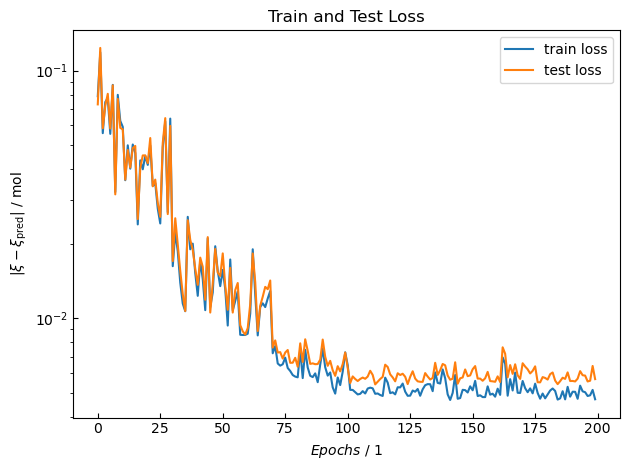

In [9]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

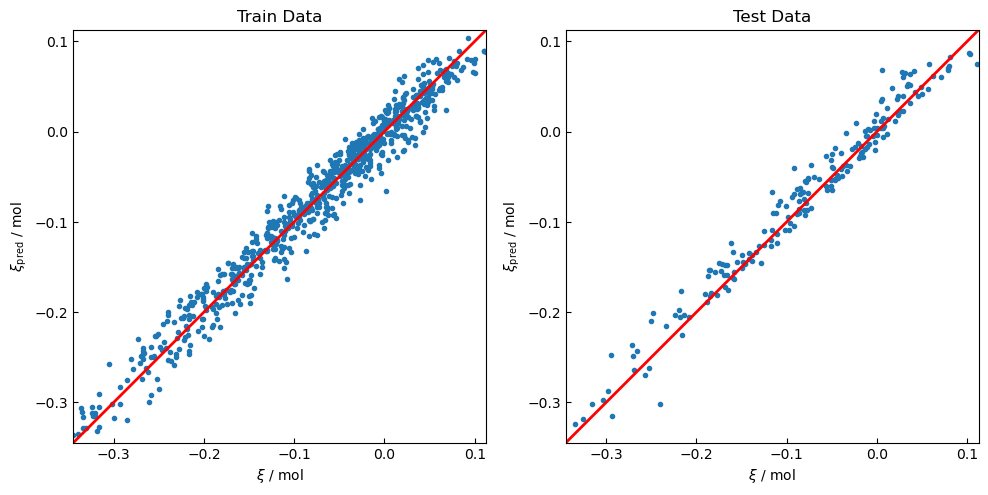

In [43]:
xi_real = []
xi_pred = []
for (X,y) in train_dataloader:
    xi_real = np.append(xi_real, y.numpy())
    xi_pred = np.append(xi_pred, net(X).detach().numpy())

xi_real_test = []
xi_pred_test = []
for (X,y) in test_dataloader:
    xi_real_test = np.append(xi_real_test, y.numpy())
    xi_pred_test = np.append(xi_pred_test, net(X).detach().numpy())

# find the boundaries of X and Y values
bounds = (min(xi_real.min(), xi_pred.min()) - int(0.1 * xi_pred.min()), max(xi_real.max(), xi_pred.max())+ int(0.1 * xi_pred.max()))

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(xi_real, xi_pred, '.')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(xi_real_test, xi_pred_test, '.')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

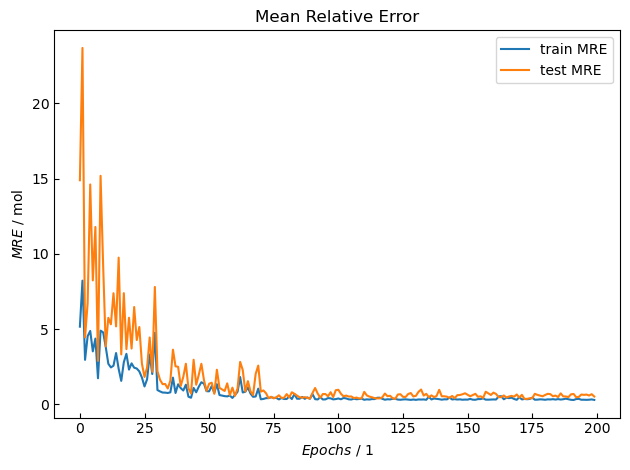

In [11]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_MRE, label='train MRE')
ax.plot(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

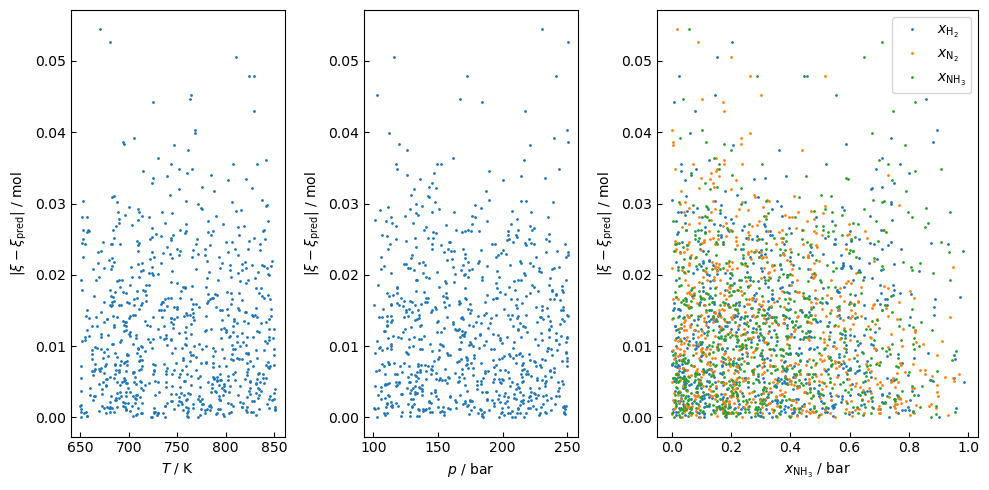

In [51]:
mistake = []
param_T = []
param_p = []
param_x_H2 = []
param_x_N2 = []
param_x_NH3 = []
for X,y in train_dataloader:
    mistake = np.append(mistake, abs(y - net(X).detach().numpy()))
    param_T = np.append(param_T, X[:,0])
    param_p = np.append(param_p, X[:,1])
    param_x_H2 = np.append(param_x_H2, X[:,2])
    param_x_N2 = np.append(param_x_N2, X[:,3])
    param_x_NH3 = np.append(param_x_NH3, X[:,4])
    
# train_parameters, train_xi = next(iter(train_dataloader))
# y = abs(train_xi - net(train_parameters).detach().numpy())
# #[T, p ,x_H2, x_N2, x_NH3]
# x = [train_parameters[:,0], train_parameters[:,1], train_parameters[:,2], train_parameters[:,3], train_parameters[:,4]]

# print(param_T[0])
# print(param_T)
# print(mistake)

fig,ax = plt.subplots(1,3, figsize = (10, 5), gridspec_kw={'width_ratios': [2,2,3]})

ax[0].plot(param_T, mistake, '.', markersize = 2)
ax[0].set(xlabel = '$T$ / K', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)

ax[1].plot(param_p, mistake, '.', markersize = 2)
ax[1].set(xlabel = '$p$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)

ax[2].plot(param_x_H2, mistake, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[2].plot(param_x_N2, mistake, '.', markersize = 2, label = '$x\mathregular{_{N_2}}$')
ax[2].plot(param_x_NH3, mistake, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[2].set(xlabel = '$x\mathregular{_{NH_3}}$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[2].tick_params(direction = 'in') #, length = 20, width = 3)
ax[2].set

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [ ]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y.reshape((-1,1)))
    print(net(X))
    break

#### Einblick in Netzwerk

In [ ]:
list(net.parameters()) # zeigt weights, biases, ...

In [ ]:
X = torch.rand((2,5))
print(X)
print(net(X))

In [ ]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [ ]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    break